In [11]:
# Imports
import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [12]:
#  Lecture des données et prétraitement
pathology_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]
bbox_pathologies = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

# Données principales
data = pd.read_csv("/kaggle/input/dataset-nih-normalise/Database_patients_normalis.csv")
data = data[['Image Index', 'Patient ID', 'View Position'] + pathology_cols]

# Lecture des bounding boxes
bbox_df = pd.read_csv("/kaggle/input/data/BBox_List_2017.csv", header=None)
bbox_df = bbox_df.iloc[:, :6]  # 6 premières colonnes utiles
bbox_df.columns = ['Image Index', 'Finding Label', 'x', 'y', 'w', 'h']

# Filtrer les maladies avec BBox uniquement
data = data[data[bbox_pathologies].sum(axis=1) > 0]

# Ajouter les chemins d'image
img_dirs = glob.glob("/kaggle/input/data/images_*/images")
img_map = {}
for d in img_dirs:
    for img in os.listdir(d):
        img_map[img] = os.path.join(d, img)
data['image_path'] = data['Image Index'].map(img_map)

# Nettoyage No Finding : un seul exemple par patient
no_finding = data[(data[pathology_cols].sum(axis=1) == 0)].drop_duplicates('Patient ID')
data = pd.concat([data[data[pathology_cols].sum(axis=1) > 0], no_finding])

# Encodage de la vue
data['view_code'] = data['View Position'].map({'PA': 0, 'AP': 1})
data = data.dropna(subset=['view_code', 'image_path'])

data = data.reset_index(drop=True)
print(f"Images totales : {len(data)}")




Images totales : 46649


In [13]:
# Génération des masques à partir des BBoxes
def generate_mask(image_name, image_size=224):
    mask = np.zeros((image_size, image_size), dtype=np.uint8)
    boxes = bbox_df[bbox_df['Image Index'] == image_name]
    for _, row in boxes.iterrows():
        x, y, w, h = row[['x', 'y', 'w', 'h']].astype(float)
        x1 = int(x / 1024 * image_size)
        y1 = int(y / 1024 * image_size)
        x2 = int((x + w) / 1024 * image_size)
        y2 = int((y + h) / 1024 * image_size)
        mask[y1:y2, x1:x2] = 1
    return mask




In [14]:
#  Dataset personnalisé pour segmentation binaire 
class SegmentationDataset(Dataset):
    def __init__(self, df, transform=None, image_size=224):
        self.df = df
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB').resize((self.image_size, self.image_size))
        mask = generate_mask(row['Image Index'], self.image_size)

        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask




In [15]:
# Split train/test et DataLoaders
train_df = data.sample(frac=0.8, random_state=42)
test_df = data.drop(train_df.index)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SegmentationDataset(train_df, transform=transform)
test_dataset = SegmentationDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)




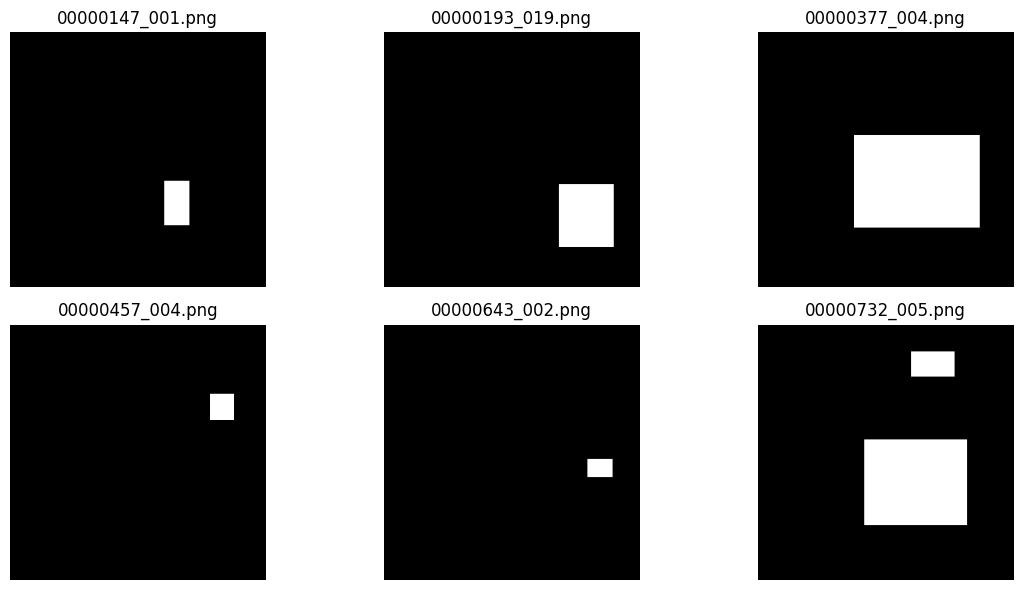

In [16]:
# ffichage uniquement des masques réels pour les images avec au moins une BBox
has_bbox = test_df['Image Index'].isin(bbox_df['Image Index'])
bbox_test_df = test_df[has_bbox].reset_index(drop=True)

plt.figure(figsize=(12, 6))
for i in range(6):
    row = bbox_test_df.iloc[i]
    mask = generate_mask(row['Image Index'], image_size=224)
    plt.subplot(2, 3, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"{row['Image Index']}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
import os
from PIL import Image

#  Créer un dossier pour exporter les images à annoter
export_dir = "/kaggle/working/annotation_set2"
os.makedirs(export_dir, exist_ok=True)

# Pathologies avec BBox dans le dataset NIH
bbox_pathologies = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
                    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

# On boucle sur chaque pathologie
for patho in bbox_pathologies:
    print(f" Extraction de : {patho}")
    patho_dir = os.path.join(export_dir, patho)
    os.makedirs(patho_dir, exist_ok=True)

    # Images contenant cette pathologie avec bbox
    matching = data[
        (data[patho] == 1) &
        (data['Image Index'].isin(bbox_df[bbox_df['Finding Label'] == patho]['Image Index']))
    ]
    matching = matching.drop_duplicates('Image Index').head(5)

    for _, row in matching.iterrows():
        img = Image.open(row['image_path']).convert("RGB")
        out_path = os.path.join(patho_dir, row['Image Index'])
        img.save(out_path)

print("Export terminé. Tu peux maintenant les télécharger dans /kaggle/working/annotation_set2")


 Extraction de : Atelectasis
 Extraction de : Cardiomegaly
 Extraction de : Effusion
 Extraction de : Infiltration
 Extraction de : Mass
 Extraction de : Nodule
 Extraction de : Pneumonia
 Extraction de : Pneumothorax
Export terminé. Tu peux maintenant les télécharger dans /kaggle/working/annotation_set2


In [18]:
import shutil

# Créer une archive ZIP du dossier annotation_set
shutil.make_archive("/kaggle/working/annotation_set2", 'zip', "/kaggle/working/annotation_set2")

print("Fichier ZIP créé : annotation_set2.zip")


Fichier ZIP créé : annotation_set2.zip


In [19]:


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

#  Dossier contenant les images exportées
root_dir = "/kaggle/working/annotation_set2"

# Chargement des BBoxes
bbox_df = pd.read_csv("/kaggle/input/data/BBox_List_2017.csv", header=None)
bbox_df.columns = ['Image Index', 'Finding Label', 'x', 'y', 'w', 'h', 'c1', 'c2', 'c3']  # on garde les 6 premiers champs utiles


In [20]:
import os
import shutil
from PIL import Image
import zipfile

# Dossiers
bbox_pathology = "Mass"
export_dir = "/kaggle/working/mass_bbox_selection"
os.makedirs(export_dir, exist_ok=True)

# Filtrer 20 images avec BBox pour "Mass"
mass_with_bbox = data[(data[bbox_pathology] == 1) & (data['Image Index'].isin(bbox_df['Image Index']))]
mass_with_bbox = mass_with_bbox.drop_duplicates('Image Index').head(20)

# Sauvegarde des images
for _, row in mass_with_bbox.iterrows():
    src_path = row['image_path']
    dst_path = os.path.join(export_dir, row['Image Index'])
    img = Image.open(src_path).convert("RGB")
    img.save(dst_path)

# Compression du dossier
shutil.make_archive(export_dir, 'zip', export_dir)
print(" Dossier zip prêt à télécharger.")


 Dossier zip prêt à télécharger.


In [21]:
import os
from PIL import Image

# Nouveau dossier pour les BBoxes uniquement de type "Mass"
export_dir = "/kaggle/working/bbox_mass_only"
os.makedirs(export_dir, exist_ok=True)

# Filtrer les BBoxes associées uniquement à la pathologie "Mass"
mass_bboxes = bbox_df[bbox_df['Finding Label'] == 'Mass']
mass_images = mass_bboxes['Image Index'].unique()[:20]  # Prendre 20 max

for img_name in mass_images:
    img_path = data[data['Image Index'] == img_name]['image_path'].values[0]
    img = Image.open(img_path).convert("RGB")
    img.save(os.path.join(export_dir, img_name))

print(f" {len(mass_images)} images avec uniquement des BBoxes 'Mass' exportées.")


 20 images avec uniquement des BBoxes 'Mass' exportées.


In [22]:
# Liste des noms des images des masques déjà faits (à adapter si besoin)
existing_mask_images = [
    "00000830_000.png",
    "00000902_001.png",
    "00001075_024.png",
    "00001836_082.png",
    "00002106_000.png",
    "00003440_000.png",
    "00005532_019.png",
    "00008008_027.png",
    "00009229_007.png",
    "00010125_004.png"
]

# Ajouter ces images au dossier si elles ne sont pas déjà présentes
for img_name in existing_mask_images:
    dst_path = os.path.join(export_dir, img_name)
    if not os.path.exists(dst_path):
        match = data[data['Image Index'] == img_name]
        if not match.empty:
            src_path = match['image_path'].values[0]
            Image.open(src_path).convert("RGB").save(dst_path)
            print(f"✅ Ajoutée : {img_name}")
        else:
            print(f"❌ Image non trouvée dans les métadonnées : {img_name}")
    else:
        print(f"ℹ️ Déjà présente : {img_name}")


ℹ️ Déjà présente : 00000830_000.png
ℹ️ Déjà présente : 00000902_001.png
ℹ️ Déjà présente : 00001075_024.png
ℹ️ Déjà présente : 00001836_082.png
ℹ️ Déjà présente : 00002106_000.png
ℹ️ Déjà présente : 00003440_000.png
ℹ️ Déjà présente : 00005532_019.png
ℹ️ Déjà présente : 00008008_027.png
ℹ️ Déjà présente : 00009229_007.png
ℹ️ Déjà présente : 00010125_004.png


In [23]:
import shutil

# Compression du dossier bbox_mass_only en bbox_mass_only.zip
shutil.make_archive("/kaggle/working/bbox_mass_only", 'zip', "/kaggle/working/bbox_mass_only")

print(" Dossier compressé avec succès. Téléchargeable ici : /kaggle/working/bbox_mass_only.zip")


 Dossier compressé avec succès. Téléchargeable ici : /kaggle/working/bbox_mass_only.zip


In [24]:
import ipywidgets as widgets

# Changer le dossier ici ⬇
available_images = sorted(os.listdir("/kaggle/working/bbox_mass_only"))

dropdown = widgets.Dropdown(
    options=available_images,
    description='Image:',
    layout=widgets.Layout(width='50%')
)

def display_image_with_mass_bbox(image_name):
    img_path = os.path.join("/kaggle/working/bbox_mass_only", image_name)
    img = Image.open(img_path)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, cmap='gray')

    # 🎯 Filtrer uniquement les BBoxes de type 'Mass' pour cette image
    for _, row in bbox_df[(bbox_df['Image Index'] == image_name) & 
                          (bbox_df['Finding Label'] == 'Mass')].iterrows():
        x, y, w, h = map(float, [row['x'], row['y'], row['w'], row['h']])
        label = row['Finding Label']

        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, label, color='yellow', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    ax.set_title(f"{image_name} - BBox: Mass")
    ax.axis('off')
    plt.show()

# Lancer le widget
widgets.interact(display_image_with_mass_bbox, image_name=dropdown)


interactive(children=(Dropdown(description='Image:', layout=Layout(width='50%'), options=('00000830_000.png', …

<function __main__.display_image_with_mass_bbox(image_name)>

In [25]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import ipywidgets as widgets
from IPython.display import display

#  Dossiers
json_dir = "/kaggle/input/masse-mask/Mask_Mass"
image_dir = "/kaggle/working/bbox_mass_only"
image_size = (224, 224)

# Liste des noms d'image disponibles
mask_jsons = [f for f in os.listdir(json_dir) if f.endswith(".json")]
image_names = [f.replace("_Mask.json", ".png") for f in mask_jsons]

# Fonction d'affichage image + masque
def show_image_and_mask(image_name):
    json_name = image_name.replace(".png", "_Mask.json")
    json_path = os.path.join(json_dir, json_name)
    image_path = os.path.join(image_dir, image_name)

    img = Image.open(image_path).convert("RGB")
    orig_size = img.size
    img_resized = img.resize(image_size)

    mask = Image.new('L', image_size, 0)

    # Charger JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    for meta in data['_via_img_metadata'].values():
        if meta['filename'] != image_name:
            continue

        draw = ImageDraw.Draw(mask)
        for region in meta['regions']:
            shape = region['shape_attributes']
            if shape['name'] == 'polyline':
                x = shape['all_points_x']
                y = shape['all_points_y']
                points = [
                    (x[i] * image_size[0] / orig_size[0], y[i] * image_size[1] / orig_size[1])
                    for i in range(len(x))
                ]
                draw.polygon(points, outline=1, fill=1)

    # Affichage
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title(f"Image : {image_name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Masque")
    plt.axis('off')

    plt.show()

# Menu déroulant interactif
widgets.interact(show_image_and_mask, image_name=widgets.Dropdown(
    options=image_names,
    description='Image :',
    layout=widgets.Layout(width='50%')
))


interactive(children=(Dropdown(description='Image :', layout=Layout(width='50%'), options=('00001075_024.png',…

<function __main__.show_image_and_mask(image_name)>

# Modèle Unet

In [26]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split




In [27]:

IMAGE_DIR = "/kaggle/working/bbox_mass_only"
MASK_DIR = "/kaggle/input/masse-mask/Mask_Mass"
IMAGE_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [28]:

class MassSegmentationDataset(Dataset):
    def __init__(self, image_names, transform=None):
        self.image_names = image_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(IMAGE_DIR, img_name)
        image = Image.open(img_path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))

        # Charger masque associé si disponible
        json_name = img_name.replace(".png", "_Mask.json")
        json_path = os.path.join(MASK_DIR, json_name)
        mask = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE), 0)

        if os.path.exists(json_path):
            import json
            from PIL import ImageDraw
            with open(json_path, 'r') as f:
                data = json.load(f)

            for meta in data['_via_img_metadata'].values():
                regions = meta['regions']
                if isinstance(regions, dict):
                    regions = list(regions.values())

                draw = ImageDraw.Draw(mask)
                for region in regions:
                    shape = region['shape_attributes']
                    if shape['name'] == 'polyline':
                        points = list(zip(shape['all_points_x'], shape['all_points_y']))
                        scaled = [
                            (x * IMAGE_SIZE / 1024, y * IMAGE_SIZE / 1024)
                            for x, y in points
                        ]
                        draw.polygon(scaled, outline=1, fill=1)

        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)

        return image, mask




In [29]:

all_images = sorted(os.listdir(IMAGE_DIR))
train_imgs, test_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = MassSegmentationDataset(train_imgs, transform)
test_dataset = MassSegmentationDataset(test_imgs, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)




In [30]:

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.dec3 = CBR(512 + 256, 256)
        self.dec2 = CBR(256 + 128, 128)
        self.dec1 = CBR(128 + 64, 64)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))




In [31]:

model = UNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS} - Loss: {total_loss / len(train_loader):.4f}")





Epoch 1/20 - Loss: 0.6674
Epoch 2/20 - Loss: 0.5992
Epoch 3/20 - Loss: 0.3103
Epoch 4/20 - Loss: 0.2701
Epoch 5/20 - Loss: 0.2441
Epoch 6/20 - Loss: 0.2340
Epoch 7/20 - Loss: 0.2250
Epoch 8/20 - Loss: 0.2074
Epoch 9/20 - Loss: 0.2020
Epoch 10/20 - Loss: 0.2166
Epoch 11/20 - Loss: 0.2228
Epoch 12/20 - Loss: 0.2217
Epoch 13/20 - Loss: 0.2133
Epoch 14/20 - Loss: 0.2044
Epoch 15/20 - Loss: 0.2112
Epoch 16/20 - Loss: 0.1852
Epoch 17/20 - Loss: 0.1970
Epoch 18/20 - Loss: 0.1801
Epoch 19/20 - Loss: 0.2038
Epoch 20/20 - Loss: 0.2070


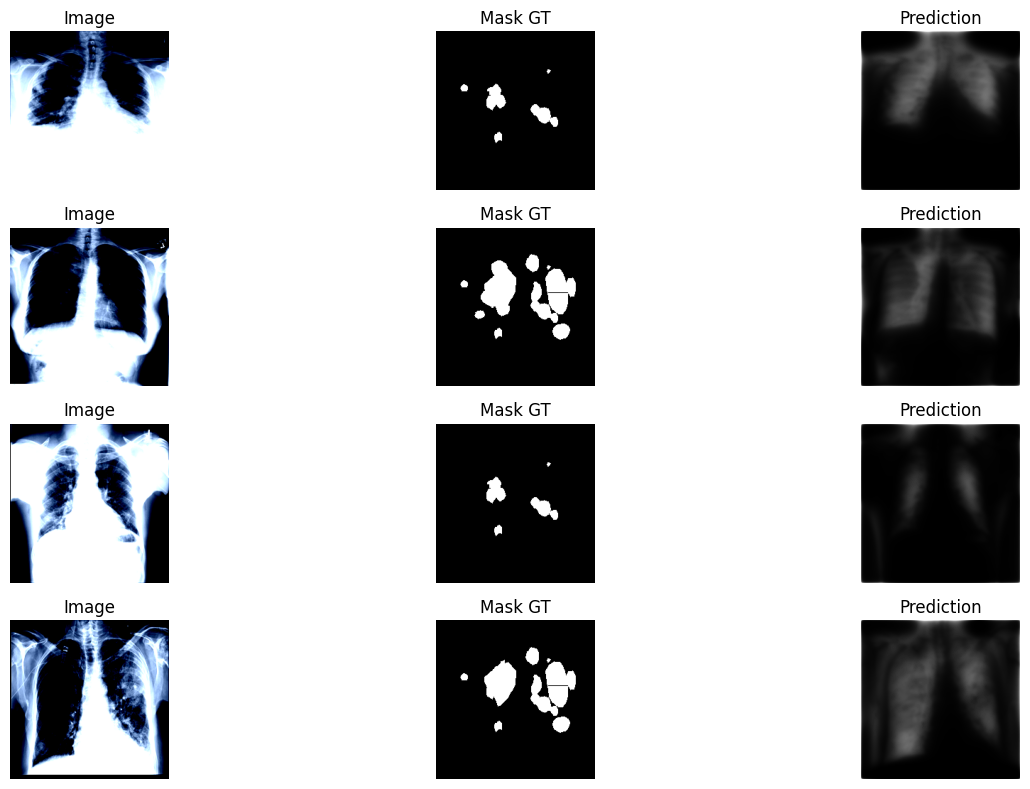

In [32]:

model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(DEVICE)
    preds = model(images).cpu().squeeze(1).numpy()
    images = images.cpu().permute(0, 2, 3, 1).numpy()

    plt.figure(figsize=(15, 8))
    for i in range(len(images)):
        plt.subplot(len(images), 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')

        plt.subplot(len(images), 3, i*3+2)
        plt.imshow(masks[i][0], cmap='gray')
        plt.title("Mask GT")
        plt.axis('off')

        plt.subplot(len(images), 3, i*3+3)
        plt.imshow(preds[i], cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()